In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from pykrige.uk import UniversalKriging

Generic import statements

In [2]:
locations = [np.array([1, 12, 1]), np.array([5, 2, 1]), np.array([12, 15, 1]), np.array([4, 2, 1]), np.array([7, 14, 1]), np.array([16, 5, 1]), np.array([2, 19, 1]), np.array([13, 0, 1]), np.array([4, 14, 1]), np.array([4, 5, 1]), np.array([4, 10, 1]), np.array([18, 11, 1]), np.array([9, 13, 1]), np.array([19, 5, 1]), np.array([13, 6, 1]), np.array([13, 8, 1]), np.array([5, 14, 1]), np.array([18, 9, 1]), np.array([1, 16, 1]), np.array([5, 17, 1])]

Defining a set of locations - each location vector has three values, namely: s1, s2, and t

In [3]:
def plot_gpr (gpr_model, time, fig, coords):
    x_axis = np.outer(np.array(range(20)), np.ones(20))
    y_axis = x_axis.copy().T
    
    # generate z
    z_axis = []
    for x in range(20):
        row = list(map(lambda r: r[0], gpr_model.sample_y(list(map(lambda y: np.array([x, y, time]), range(20))))))
        z_axis.append(row)

    if fig:
        ax = fig.add_subplot(*coords, projection = '3d')
    else:
        ax = plt.axes(projection = '3d')
    ax.plot_surface(x_axis, y_axis, np.array(z_axis), cmap = 'nipy_spectral', vmin = -150, vmax = 50)
    ax.set_title('Predicted at t={}'.format(time))

Here we define a plotting function to plot the generated graph

In [4]:
def cell_val (loc):
    return loc[0] + loc[1] + round(random.uniform(0, 10), 2)
    # 25% noise in a range of 0-40
board = []
for loc in locations:
    board.append(cell_val(loc))
gpr = GaussianProcessRegressor(kernel = DotProduct() + WhiteKernel()).fit(locations, board)

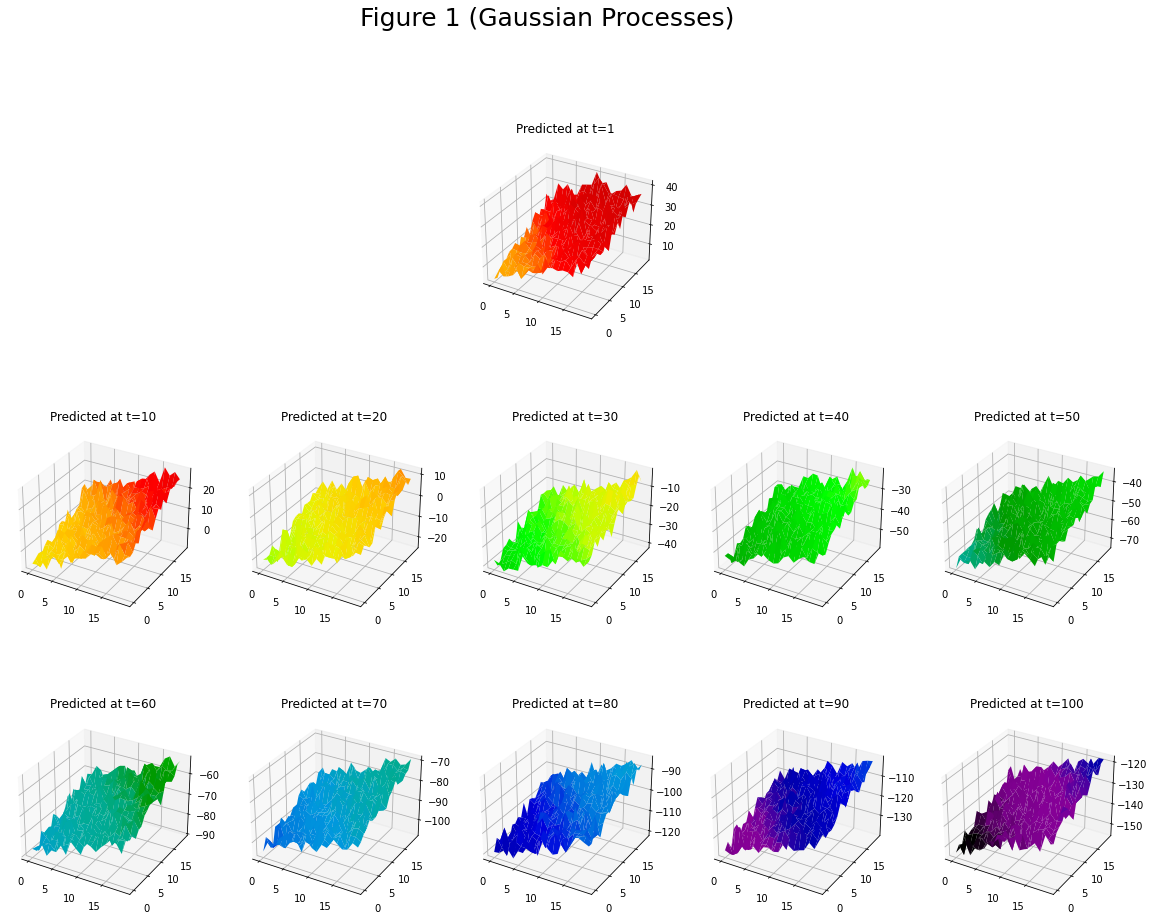

In [5]:
fig1 = plt.figure(figsize = [20, 15])
fig1.suptitle('Figure 1 (Gaussian Processes)', fontsize = 25)

plot_gpr(gpr, 1, fig1, [3, 5, 3])
plot_gpr(gpr, 10, fig1, [3, 5, 6])
plot_gpr(gpr, 20, fig1, [3, 5, 7])
plot_gpr(gpr, 30, fig1, [3, 5, 8])
plot_gpr(gpr, 40, fig1, [3, 5, 9])
plot_gpr(gpr, 50, fig1, [3, 5, 10])
plot_gpr(gpr, 60, fig1, [3, 5, 11])
plot_gpr(gpr, 70, fig1, [3, 5, 12])
plot_gpr(gpr, 80, fig1, [3, 5, 13])
plot_gpr(gpr, 90, fig1, [3, 5, 14])
plot_gpr(gpr, 100, fig1, [3, 5, 15])

These graphs show a strong tendency to decrease linearly in value as time increases. This is because there are no other time values to 'correct' this tendency.

This net graph, from appearance, looks to be of the form Z(x, y, t) = x + y - t + Δ

We now proceed with the Kriging step.

In [6]:
kriging_locations = np.array([[1, 10], [14, 18], [17, 0], [14, 11], [4, 1], [1, 6], [2, 0], [1, 9], [0, 13], [11, 7], [16, 5], [9, 2], [19, 13], [3, 17], [17, 19], [14, 8], [13, 16], [9, 16], [12, 13], [18, 12]])

Here, we generate the entire dataset using Kriging at timestamps (t=1, t=10, t=20... t=100) as examples of the changes created. If required, these values can be calculated for any value of t.

In [7]:
def plot_krige (z, time, fig, coords):
    x_axis = np.outer(np.array(range(20)), np.ones(20))
    y_axis = x_axis.copy().T
    if fig:
        ax = fig.add_subplot(*coords, projection = '3d')
    else:
        ax = plt.axes(projection = '3d')
    ax.plot_surface(x_axis, y_axis, np.array(z), cmap = 'nipy_spectral', vmin = -150, vmax = 50)
    ax.set_title('Kriged at t={}'.format(time))

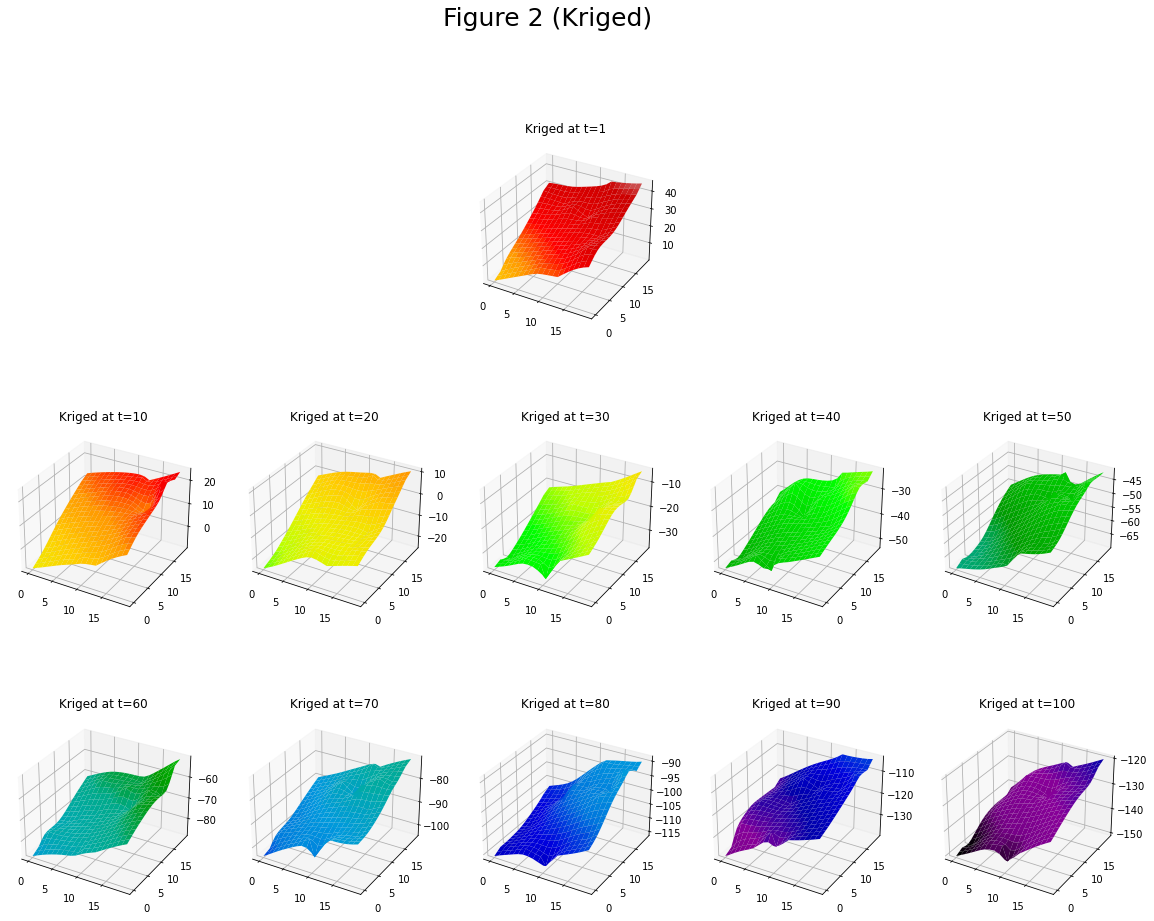

In [8]:
fig2 = plt.figure(figsize = [20, 15])
fig2.suptitle('Figure 2 (Kriged)', fontsize = 25)

indexes = [
  15, 14, 13, 12, 11,
  10,  9,  8,  7,  6,
   3
]

deltas = []

for time in [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    vals = gpr.sample_y(list(map(lambda loc: [*loc, time], kriging_locations)))
    UK = UniversalKriging(kriging_locations[:, 0], kriging_locations[:, 1], vals, variogram_model = "linear", drift_terms = ["regional_linear"])
    z, ss = UK.execute("grid", np.arange(0.0, 20.0, 1.0), np.arange(0.0, 20.0, 1.0))
    deltas.append(z - vals)
    plot_krige(z, time, fig2, [3, 5, indexes.pop()])
    

Since we chose to try and Krige the data to a linear function, we can see a strong linear tendency, and the generated graph is smoother than the Gaussian one.

In [9]:
def plot_deltas (z, time, fig, coords):
    x_axis = np.outer(np.array(range(20)), np.ones(20))
    y_axis = x_axis.copy().T
    if fig:
        ax = fig.add_subplot(*coords, projection = '3d')
    else:
        ax = plt.axes(projection = '3d')
    ax.plot_surface(x_axis, y_axis, np.array(z), cmap = 'seismic', vmin = -200, vmax = 200)
    ax.set_title('Differences at t={}'.format(time))

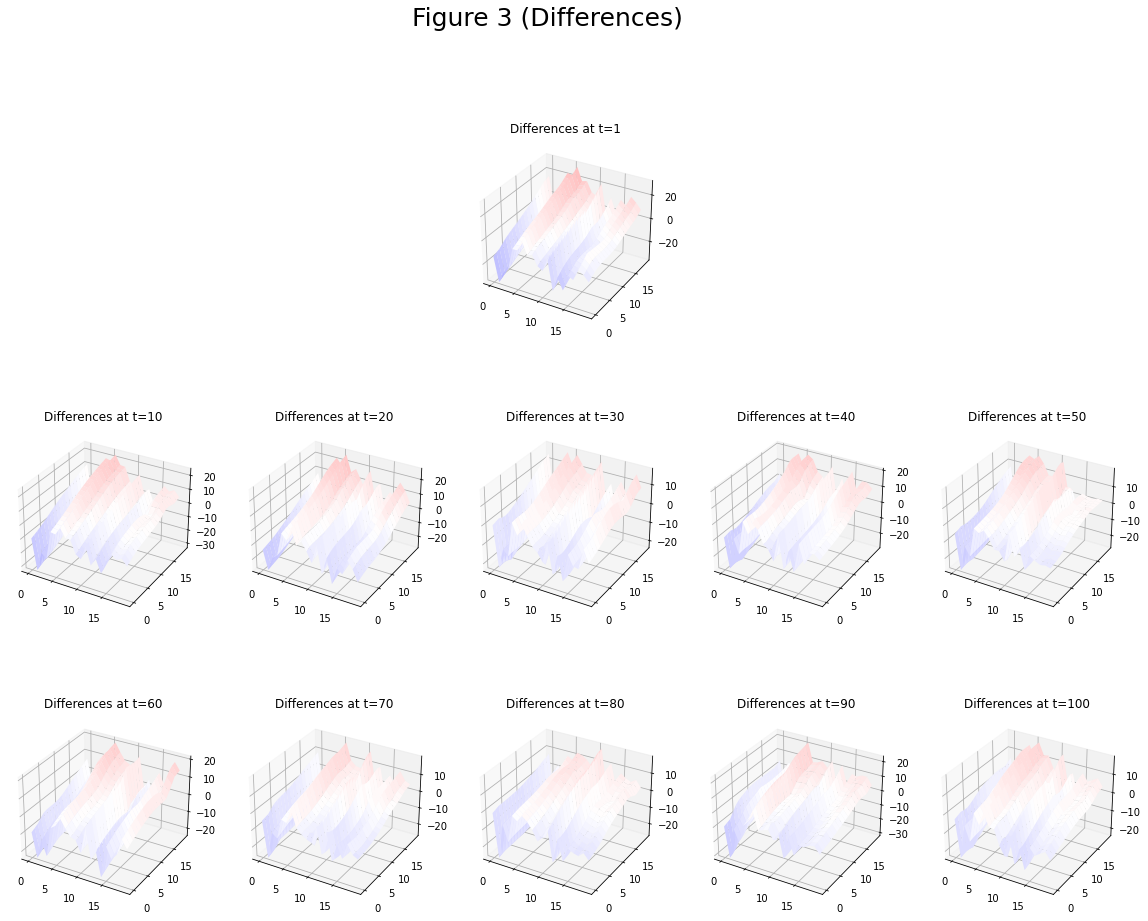

In [10]:
fig3 = plt.figure(figsize = [20, 15])
fig3.suptitle('Figure 3 (Differences)', fontsize = 25)

indexes = [
  15, 14, 13, 12, 11,
  10,  9,  8,  7,  6,
   3
]

for index, time in enumerate([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    plot_deltas(deltas[index], time, fig3, [3, 5, indexes.pop()])

As you can see, while there are small differences between the two, these are noticeably smaller than the actual values. We can also notice a strong correlation between the difference graphs at various times.

Moving on to the next part, we create a new initialization.

In [11]:
spatial_locs = [np.array([1, 9]), np.array([9, 7]), np.array([12, 13]), np.array([17, 14]), np.array([12, 12])]
temporal_locs = np.array([60, 76, 85, 9, 80])
temporal_locs.sort()

In [12]:
def plot_gprt (gpr_model, time, fig, coords):
    x_axis = np.outer(np.array(range(20)), np.ones(20))
    y_axis = x_axis.copy().T
    
    # generate z
    z_axis = []
    for x in range(20):
        row = list(map(lambda r: r[0], gpr_model.sample_y(list(map(lambda y: np.array([x, y]), range(20))))))
        z_axis.append(row)

    if fig:
        ax = fig.add_subplot(*coords, projection = '3d')
    else:
        ax = plt.axes(projection = '3d')
    ax.plot_surface(x_axis, y_axis, np.array(z_axis), cmap = 'nipy_spectral', vmin = 0, vmax = 120)
    ax.set_title('Predicted at t={}'.format(time))

def new_cell_val (x, y, t):
    return x + y + t / 2 + round(random.uniform(0, 20), 2)
    # 11% noise in a range of 0-180

Defining the spatial GPs at each point in time

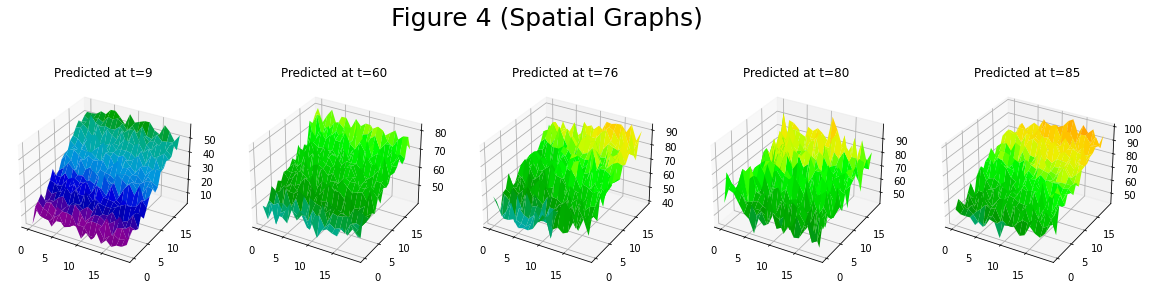

In [15]:
fig4 = plt.figure(figsize = [20, 5])
fig4.suptitle('Figure 4 (Spatial Graphs)', fontsize = 25)

for index, time in enumerate(temporal_locs):
    gprt = GaussianProcessRegressor(kernel = DotProduct() + WhiteKernel()).fit(spatial_locs, list(map(lambda loc: new_cell_val(*loc, time), spatial_locs)))
    plot_gprt(gprt, time, fig4, [1, 5, index + 1])

Here, we can see the generic tendencies of the graphs. We can also notice that the 'smoothness' of each spatial graph is random and depends on how much 'noise' occurred during each set of points. Now, we take a look at the temporal graphs.

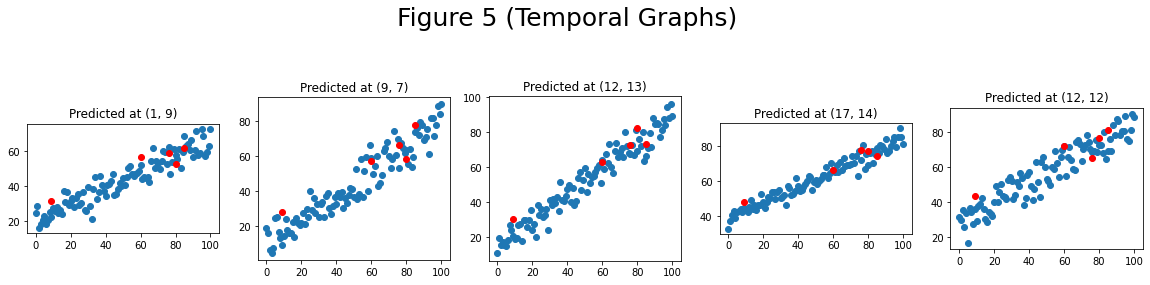

In [14]:
def plot_gprs (gpr_model, space, fig, coords, mapped):
    x_axis = range(101)
    y_axis = list(map(lambda r: r[0], gpr_model.sample_y(np.array(range(101)).reshape(-1, 1))))
    if fig:
        ax = fig.add_subplot(*coords)
    else:
        ax = plt.axes()
    ax.scatter(x_axis, np.array(y_axis))
    ax.set_aspect('equal', adjustable = 'box')
    ax.set_title('Predicted at ({}, {})'.format(*space))
    ax.scatter(temporal_locs, mapped, marker = 'o', color = 'red')
    
fig5 = plt.figure(figsize = [20, 5])
fig5.suptitle('Figure 5 (Temporal Graphs)', fontsize = 25)

for index, space in enumerate(spatial_locs):
    mapped = list(map(lambda loc: new_cell_val(*space, loc), temporal_locs))
    gprs = GaussianProcessRegressor(kernel = DotProduct() + WhiteKernel()).fit(temporal_locs.reshape(-1, 1), mapped)
    plot_gprs(gprs, space, fig5, [1, 5, index + 1], mapped)

Here, we can see that the lines seem to be roughly following a straight line of slope 1/2, which matches up with our initial generation function.

### Summary

As we have seen, the graphs from the second question are vastly different from the ones in the first question. But why is this so?


If we look carefully, we can notice that the graphs on part I have *no time variance* - in essence, since there is no known data on how the graphs change with respect to time, we can make no reliable assumptions about any temporal tendencies. Because of this, the algorithm faces no decrease in variance while moving on the time dimension, and the initially chosen direction of linear decreasing with time was selected. Because of this, we notice the graphs in the first part gradually decreasing in value.

On the other hand, in part II, we now have a noticeable tendency with respect to change in time, as indicated by the graphs in Fig. 5